# 기본 함수 및 라이브러리 로드

In [1]:
# 경고 제어
import warnings
warnings.filterwarnings('ignore')

# 기본 전처리
import numpy as np
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.4f}'.format

# 시각화
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12, 9)
from scipy.stats import norm

## 필요 함수 로드

In [2]:
def get_object_type(df):
    """ 
    상권코드의 type을 str로 바꿈
    상권_이름을 삭제
    """
    
    df['상권_코드'] = df['상권_코드'].apply(lambda x: str(x))
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
### Scaler들의 함수를 정의함 ###
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1))

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [4]:
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

def get_summary(X, y):
    """
    p-value를 체크하는 한다
    """
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

## 검정 함수

### vif 관련 함수

In [5]:
least = 1000

In [6]:
def get_vif(X, least=100, show=False):
    """
    vif를 구하고 이를 데이터 프레임화
    초기 vif 제한수를 100으로 지정
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    
    if show:
        print(vif, '\n')
        
    vif = vif[vif['features'] != 'const']
    return vif[vif['VIF Factor'] > least]

### AIC 기반 회귀 함수

In [7]:
def processSubset(X, y, feature_set):
    """
    OLS 기반으로 하여 
    모델, AIC 점수, data, Feature들을 출력한다
    
    후에 getBest 함수에서 루프를 타고서
    AIC 점수들을 비교하여 가장 낮은 점수를 출력하는데 도움을 준다
    """
    feature = list(feature_set)
    model = sm.OLS(y, X[feature])
    regr = model.fit()
    AIC = regr.aic
    data = regr.summary()
    
    return {'model': regr, 'AIC': AIC, 'SUMMARY':data, 'Features':feature}

In [8]:
import time
import itertools

def getBest(X, y, k):
    """ 
    k개의 Feature들의 조합 중 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수
    출력물은 model, k개에 맞는 feature, AIC 점수 
    """
    
    results = []           # 결과 저장 공간
    # 절편 컬럼을 제외한 모든 X컬럼의 경우의 수를 조합
    iters = itertools.combinations(X.columns.difference(['const']), k) 
    
    for combo in iters:
        # 상수항을 추가하여 combo를 결성
        combo = (list(combo)+['const'])
        results.append(processSubset(X, y, feature_set = combo)) # 모델링된 것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분헉하여
        # 저장 후 그중 AIC가 가장 낮은 모델을 선택하도록 함
        
    models = pd.DataFrame(results)     # 데이터 프레임으로 모델결과 반환
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

##### 전진 선택법

In [9]:
def forward(X, y, predictors):
    """
    forward 함수에서는 const를 제외한 모든 feature들을 포함한 AIC 점수를 반환한다.
    predictor는 forward_model에서 정의된 매개변수다.
    forward_model의 predictor에 AIC score를 계산하기 위한 변수들이 저장되며
    그 저장된 변수들을 제외하고서 다시 AIC score를 계산하기 위한 함수
    """
    # predictor - 현재 선택되어 있는 변수
    # 데이터 변수들이 미리 정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors + [p] + ['const']))
        
    # 데이터 프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
#     print('Processed ', models.shape[0], 'models on', len(predictors)+1)
#     print('Selected predictors:', best_model['model'].model.exog_names, 'AIC: ', best_model[0])
    
    return best_model

def forward_model(X, y):
    """
    전진선택법 모델
    loop를 돌며 forward 함수를 실행시키며 AIC score를 계산하고
    이에 대한 정보를 저장하며 갱신해 나간다.
    loop를 한번 돌때 쓰인 feature들은 predictors에 저장되며 
    이는 forward 함수를 작동할 때 사용되지 않는 용도로 쓰인다.
    """
    Fmodels = pd.DataFrame(columns=['AIC', 'model', 'SUMMARY', 'Features'])
    
    # 미리 정의된 데이터 변수
    # forward에서 AIC를 구할 때 여기에 저장된 변수는 제거하고 계산한다
    predictors = [ ]
    
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X, y, predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                ### AIC 점수가 전의 점수보다 높으면 더이상 loop를 돌지 않고 종료 ###
                break
        Fmodels.loc[i] = Forward_result
        # loop를 돌면서 getBest으로부터(Forward 내부) 계산된 독립변수들이 predictors에 저장됨
        predictors = Fmodels.loc[i]['model'].model.exog_names
        Fmodel_before = Fmodels.loc[i]['AIC']
        ### const를 제외한 변수가 추가된다. ###
        predictors = [ k for k in predictors if k != 'const' ]
    return Fmodels

##### 후진소거법

In [10]:
def backward(X, y, predictors):
    """
    backward_model을 실행하기 위한 선행 함수
    이 함수에서 back_ward의 predictors에 담긴 feature를 토대로 AIC score를 계산하고 저장한다
    
    for문에서 itertools의 combination을 통해 predictors의 숫자 중 -1의 조합으로 가능한 경우의 수를 구한다.
    예) predictors = 6 일때 6C5 => 6개의 경우의 수 도출
    
    for문을 벗어나면 DataFrame에 저장된 AIC score 중 가장 낮은 레코드를 반환함
    """
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X, y, feature_set=list(combo) + ['const']))
    models = pd.DataFrame(results)

    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

def backward_model(X, y):
    """
    후진소거법
    backward_model은 'const'를 제외한 모든 feature들을 predictors에 저장하고 시작한다.
    AIC를 저장하는 Bmodel_before 변수의 초기값은 'const'를 제외한 모든 feature들을 고려한 AIC 값을 저장하고
    이후 while문을 거치며 새로운 값으로 갱신함
    
    while 문 안에 있는 predictors에서 변수의 갯수를 최신화 하는데
    이는 backward 함수 안에서 feature의 갯수를 하나씩 줄여나간다.
    그리고 backward 함수에서 len(feature) Combination len(featrue)-1 의 경우의 수로 AIC score를 계산함
    
    while문 종료 조건은 2가지로 나눠진다.
    1. 계산된 AIC가 이전 AIC보다 높을 시
    2. 모든 변수를 사용했을시
    """
    Bmodels = pd.DataFrame(columns= ['AIC', 'model', 'SUMMARY', 'Features'], index=range(1, len(X.columns)))
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X, y, predictors)['AIC']
    
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X, y, predictors)
        
        # loop를 거치고 계산된 AIC가 이전 AIC보다 높으면 loop 종료
        if Backward_result['AIC'] > Bmodel_before:
            break
        
        Bmodels.loc[idx] = Backward_result
        # model에 쓰인 feature들을 최신화 (이후 backward 함수에서 이 저장된 len(feature) combination len(feature)-1로 계산한다)
        # backward 함수에서 feature의 갯수가 하나 줄어든다.
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const' ]
        idx += 1
        
    return Bmodels.dropna()

##### 단계적 선택법

In [11]:
def Stepwise_model(X, y):
    """
    단계적 선택법
    초기 predictors는 X의 모든 Feature, 
    초기 AIC score는 모든 Feature들이 고려된 score로 시작
    
    후에 loop를 돌며 forward, backward 함수를 실행시켜 두 AIC 점수를 비교한다.
    둘 중 작은 AIC 점수를 저장하고 Feature를 최신화한다.
    """
    Stepmodels = pd.DataFrame(columns = ['AIC', 'model', 'SUMMARY', 'Features'])
    predictors = []
    # 모든 Feature들이 고려된 AIC score
    Stepmodels.loc[0] = getBest(X, y, k=1)
    predictors = Stepmodels.loc[0]['model'].model.exog_names
    predictors = [ k for k in predictors if k != 'const' ]
    Smodel_before = Stepmodels.loc[0]['AIC']

    for i in range(2, len(X.columns.difference(['const'])) + 1):
        
        Forward_result = forward(X, y, predictors)
        Backward_result = backward(X, y, predictors)

        
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_name
            predictors = [ k for k in predictors if k != 'const' ]
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
            
        if Stepmodels.loc[i]['AIC'] > Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
            
    return Stepmodels

##### **AIC 시각화**

In [12]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC = result['AIC'].to_list()
    features = [f'step {i+1}\n' + '\n'.join(s) for i, s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps, AIC, marker='o')
    
    plt.ylabel('AIC', fontsize=font_size)
    plt.grid(True)
    plt.show()

### 최적화 함수

In [13]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

# Data Load

In [14]:
df_i1_development = pd.read_csv('./data/indicator/상권_발달_지수.csv')
df_i1_development.head(3)

,상권_코드,1년_매출,점포수,점포_증가량,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,월요일_생활인구_수,화요일_생활인구_수,수요일_생활인구_수,목요일_생활인구_수,금요일_생활인구_수,토요일_생활인구_수,일요일_생활인구_수
0,1000001,15126572384.0000,213,-3,4324568,2193021,2131546,539326,613811,830622,871492,666560,802756,784753,966918,737816,731799,700663,402616,648404,671523,663182,661833,647096,530394,502137
1,1000002,15994662318.0000,103,-12,14572603,7302651,7269951,1139824,2395368,2778982,2495751,2420125,3342559,2987914,3058515,2246600,2253728,2449248,1576598,2100487,2113428,2114383,2104128,2088132,2027654,2024391
2,1000003,28743293882.0000,362,-4,6931076,3966981,2964095,346596,1290132,1298139,1276708,1135201,1584302,904485,1347371,1311840,1383582,1411510,572292,1039460,1085002,1079350,1072242,1058901,872185,723940


In [15]:
df_coeff = pd.read_csv('./data/coeff/18~21_총_매출_회귀계수.csv')
df_coeff.head()

,상권_코드,coef
0,1000001,-97196952.6813
1,1000002,-391099844.1758
2,1000003,-363763315.6978
3,1000004,-189218466.3516
4,1000005,-158004852.5055


In [27]:
df_full = pd.merge(df_i1_development, df_coeff, on='상권_코드')
df_full = df_full.set_index('상권_코드')
df_full.head()

,1년_매출,점포수,점포_증가량,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,월요일_생활인구_수,화요일_생활인구_수,수요일_생활인구_수,목요일_생활인구_수,금요일_생활인구_수,토요일_생활인구_수,일요일_생활인구_수,coef
상권_코드,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,15126572384.0000,213,-3,4324568,2193021,2131546,539326,613811,830622,871492,666560,802756,784753,966918,737816,731799,700663,402616,648404,671523,663182,661833,647096,530394,502137,-97196952.6813
1000002,15994662318.0000,103,-12,14572603,7302651,7269951,1139824,2395368,2778982,2495751,2420125,3342559,2987914,3058515,2246600,2253728,2449248,1576598,2100487,2113428,2114383,2104128,2088132,2027654,2024391,-391099844.1758
1000003,28743293882.0000,362,-4,6931076,3966981,2964095,346596,1290132,1298139,1276708,1135201,1584302,904485,1347371,1311840,1383582,1411510,572292,1039460,1085002,1079350,1072242,1058901,872185,723940,-363763315.6978
1000004,10722057960.0000,138,-9,12659811,5925747,6734063,2163623,3794991,1379547,1648944,1389617,2283089,3889185,2756008,1390214,1270606,1725169,1628625,1821418,1831914,1822679,1820578,1780184,1767680,1815363,-189218466.3516
1000005,10434746482.0000,77,2,1840860,865152,975711,269838,212859,216631,325791,312262,503478,496022,401417,219594,210490,277669,235668,257712,260156,262067,259023,261080,268340,272482,-158004852.5055


# 다중공선성

In [24]:
threshold = 0.5
drop_pearson_list = df_full.corr()['coef'][df_full.corr()['coef']>threshold].index.to_list()[1:]
drop_pearson_list

[]

In [25]:
get_vif(df_full)

,VIF Factor,features
4,30429727211962.8125,총_생활인구_수
5,4981857994878.8672,남성_생활인구_수
6,6627814021148.6328,여성_생활인구_수
7,291381963468.5880,연령대_10_생활인구_수
8,457706146386.5538,연령대_20_생활인구_수
9,381822774681.6868,연령대_30_생활인구_수
10,273783375018.7237,연령대_40_생활인구_수
11,240982402406.3192,연령대_50_생활인구_수
12,649682577520.2677,연령대_60_이상_생활인구_수
13,684853957933.4696,시간대_1_생활인구_수


In [34]:
df_X = df_full.iloc[:,:-1]
df_X = sm.add_constant(df_X ,has_constant = "add")
df_y = df_full['coef']

In [38]:
df_X

,const,1년_매출,점포수,점포_증가량,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,월요일_생활인구_수,화요일_생활인구_수,수요일_생활인구_수,목요일_생활인구_수,금요일_생활인구_수,토요일_생활인구_수,일요일_생활인구_수
상권_코드,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,1.0000,15126572384.0000,213,-3,4324568,2193021,2131546,539326,613811,830622,871492,666560,802756,784753,966918,737816,731799,700663,402616,648404,671523,663182,661833,647096,530394,502137
1000002,1.0000,15994662318.0000,103,-12,14572603,7302651,7269951,1139824,2395368,2778982,2495751,2420125,3342559,2987914,3058515,2246600,2253728,2449248,1576598,2100487,2113428,2114383,2104128,2088132,2027654,2024391
1000003,1.0000,28743293882.0000,362,-4,6931076,3966981,2964095,346596,1290132,1298139,1276708,1135201,1584302,904485,1347371,1311840,1383582,1411510,572292,1039460,1085002,1079350,1072242,1058901,872185,723940
1000004,1.0000,10722057960.0000,138,-9,12659811,5925747,6734063,2163623,3794991,1379547,1648944,1389617,2283089,3889185,2756008,1390214,1270606,1725169,1628625,1821418,1831914,1822679,1820578,1780184,1767680,1815363
1000005,1.0000,10434746482.0000,77,2,1840860,865152,975711,269838,212859,216631,325791,312262,503478,496022,401417,219594,210490,277669,235668,257712,260156,262067,259023,261080,268340,272482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001006,1.0000,12500919837.0000,192,-8,23077813,10501495,12576321,4213378,2557886,3044072,3480030,3664853,6117595,6164903,4671598,2639564,2683092,3873015,3045643,3246429,3222927,3238497,3238358,3243878,3388184,3499542
1001007,1.0000,17237273313.0000,253,9,5644867,2719272,2925594,832624,621469,825583,932200,1009867,1423125,1497654,1208921,664870,643614,905491,724321,815233,815079,811937,810008,808327,791197,793086
1001008,1.0000,22670426878.0000,255,1,29051057,13265448,15785612,3649775,4148806,4917155,4532666,4456759,7345897,7186883,5774602,3538545,3624425,5211404,3715196,4086683,4094625,4109122,4094429,4117178,4285464,4263558


In [40]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coef   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     25.84
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           2.89e-90
Time:                        20:19:48   Log-Likelihood:                -21204.
No. Observations:                1009   AIC:                         4.246e+04
Df Residuals:                     983   BIC:                         4.259e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -6.654e+07   3.17e+07     -2.097      0.036   -1.29e+08   -4.27e+06
1년_매출                0.0187      0.001     24.088      0.000       0.017       0.020
점포수              -2.217e+06   1.26e+05    -17.572      0.000   -2.46e+06   -1.97e+06
점포_증가량            1.535e+06   1.06e+06      1.446      0.149   -5.49e+05    3.62e+06
총_생활인구_수          6.887e+05   7.43e+06      0.093      0.926   -1.39e+07    1.53e+07
남성_생활인구_수         1.674e+06   6.44e+06      0.260      0.795    -1.1e+07    1.43e+07
여성_생활인구_수         1.674e+06   6.44e+06      0.260      0.795    -1.1e+07    1.43e+07
연령대_10_생활인구_수    -2.119e+06   4.32e+06     -0.491      0.624   -1.06e+07    6.35e+06
연령대_20_생활인구_수    -2.119e+06   4.32e+06     -0.491      0.624   -1.06e+07    6.35e+06
연령대_30_생활인구_수    -2.119e+06   4.32e+06     -0.491      0.624   -1.06e+07    6.35e+06
연령대_40_생활인구_수    -2.119e+06   4.32e+06     -0.491      0.624   -1.06e+07    6.35e+06
연령대_50_생활인구_수    -2.119e+06   4.32e+06     -0.491      0.624   -1.06e+07    6.35e+06
연령대_60_이상_생활인구_수 -2.119e+06   4.32e+06     -0.491      0.624   -1.06e+07    6.35e+06
시간대_1_생활인구_수     -3.653e+06   3.97e+06     -0.920      0.358   -1.14e+07    4.14e+06
시간대_2_생활인구_수     -3.653e+06   3.97e+06     -0.920      0.358   -1.14e+07    4.14e+06
시간대_3_생활인구_수     -3.653e+06   3.97e+06     -0.920      0.358   -1.14e+07    4.14e+06
시간대_4_생활인구_수     -3.652e+06   3.97e+06     -0.920      0.358   -1.14e+07    4.14e+06
시간대_5_생활인구_수     -3.653e+06   3.97e+06     -0.920      0.358   -1.14e+07    4.14e+06
시간대_6_생활인구_수     -3.653e+06   3.97e+06     -0.920      0.358   -1.14e+07    4.14e+06
월요일_생활인구_수        3.412e+06   3.69e+06      0.924      0.356   -3.84e+06    1.07e+07
화요일_생활인구_수        3.411e+06   3.69e+06      0.923      0.356   -3.84e+06    1.07e+07
수요일_생활인구_수        3.408e+06   3.69e+06      0.923      0.356   -3.84e+06    1.07e+07
목요일_생활인구_수        3.407e+06   3.69e+06      0.922      0.357   -3.84e+06    1.07e+07
금요일_생활인구_수        3.411e+06   3.69e+06      0.924      0.356   -3.84e+06    1.07e+07
토요일_생활인구_수        3.409e+06   3.69e+06      0.923      0.356   -3.84e+06    1.07e+07
일요일_생활인구_수         3.41e+06   3.69e+06      0.923      0.356   -3.84e+06    1.07e+07
==============================================================================
Omnibus:                     1474.454   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1105577.079
Skew:                          -7.869   Prob(JB):                         0.00
Kurtosis:                     164.398   Cond. No.                     8.93e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.93e+10.

In [35]:
s_AIC_model = Stepwise_model(df_X, df_y)

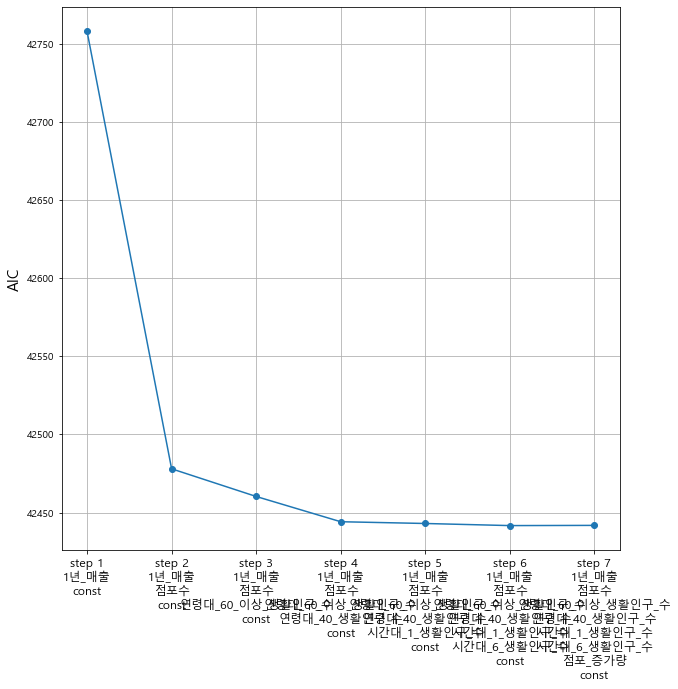

In [36]:
vis_AIC_step(s_AIC_model)

In [37]:
s_best = get_best_summary_by_A(s_AIC_model)
s_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coef   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     104.4
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          4.36e-102
Time:                        19:31:47   Log-Likelihood:                -21214.
No. Observations:                1009   AIC:                         4.244e+04
Df Residuals:                    1002   BIC:                         4.248e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
1년_매출                0.0187      0.001     24.617      0.000       0.017       0.020
점포수              -2.228e+06   1.24e+05    -17.986      0.000   -2.47e+06   -1.98e+06
연령대_60_이상_생활인구_수    48.7141     14.743      3.304      0.001      19.784      77.644
연령대_40_생활인구_수      -68.7792     21.332     -3.224      0.001    -110.639     -26.920
시간대_1_생활인구_수        83.1348     33.870      2.455      0.014      16.671     149.598
시간대_6_생활인구_수      -146.5916     80.350     -1.824      0.068    -304.266      11.082
const            -8.651e+07   2.94e+07     -2.946      0.003   -1.44e+08   -2.89e+07
==============================================================================
Omnibus:                     1466.015   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1076986.309
Skew:                          -7.784   Prob(JB):                         0.00
Kurtosis:                     162.295   Cond. No.                     8.26e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.26e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""